<a href="https://colab.research.google.com/github/YossiKimchy/Cycle-Share-System--Complex-Networks-Project/blob/main/Cycle_Share_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bicycle Trip Data from Seattle's Cycle Share System

The Pronto Cycle Share system consists of 500 bikes and 54 stations located in Seattle. Pronto provides open data on individual trips and stations.

In this project, the city bike system will be analyzed as a complex network with NetworkX package and other mathematical tools.

Within the context of transportation, the term network refers to the framework of routes within a system of locations, identified as nodes. A route is a single link between two nodes that are part of a larger network.

It is crucial to highlight that edges of the city bike network are not predetermined, they are generated by the users. Thus, the structure of the network emerges from the flow of people through the city. Reoccurring trips made by the residents gradually formulate usage patterns and create the structure of the bike-sharing network. This information, in turn, can be used in a feedback loop for the evolution of the network. Rising or decreasing bike demand can provide insights into wider sociological, economical and geographic factors in certain areas.

**Content**

There are 2 datasets that provide data on the stations and trips from 2014-2016.

1. Station dataset
* station_id: station ID number
* name: name of station
* lat: station latitude
* long: station longitude

2. Trip dataset
* trip_id: numeric ID of bike trip taken
* bikeid: ID attached to each bike
* trip_duration: time of trip in seconds
* from_station_name: name of station where trip originated
* to_station_name: name of station where trip terminated
* from_station_id: ID of station where trip originated
* to_station_id: ID of station where trip terminated

# Imports

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from networkx import generators

import scipy as sp
from scipy.optimize import curve_fit 
from scipy import stats
from scipy.stats import linregress

import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
%matplotlib inline

import seaborn as sns

import collections
from collections import Counter

from operator import itemgetter
import folium
from folium import plugins
import community as community_louvain

import warnings
warnings.simplefilter('ignore')

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

# Data Analyze

In [2]:
df_station = pd.read_csv('station.csv', index_col='station_id', usecols=['station_id','name','lat','long'])
df_trip = pd.read_csv('trip.csv', usecols=['trip_id','from_station_name','to_station_name','from_station_id','to_station_id','bikeid','tripduration'])

In [3]:
df_station.head()

,name,lat,long
station_id,,,
BT-01,3rd Ave & Broad St,47.618418,-122.350964
BT-03,2nd Ave & Vine St,47.615829,-122.348564
BT-04,6th Ave & Blanchard St,47.616094,-122.341102
BT-05,2nd Ave & Blanchard St,47.613110,-122.344208
CBD-03,7th Ave & Union St,47.610731,-122.332447


In [ ]:
df_station.info()

In [4]:
df_trip.head()

,trip_id,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id
0,431,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04
1,432,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04
2,433,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04
3,434,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04
4,435,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04


In [ ]:
df_trip.info()

In [ ]:
df_station[['long','lat']].round(3)

# Create Undirected Graph
An undirected graph is a set of nodes and a set of links between the nodes. Each node is called a vertex, each link is called an edge, and each edge connects two vertices. The order of the two connected vertices is unimportant. An undirected graph is a finite set of vertices together with a finite set of edges.

In [5]:
U = nx.Graph()

## Nodes & Edges

In [6]:
U = nx.from_pandas_edgelist(df_trip, 'from_station_name', 'to_station_name', edge_attr=['tripduration'])

## Drawing Graph

(-1.140615082985974,
 0.8567954179730959,
 -0.9201831074020436,
 1.273073444167786)

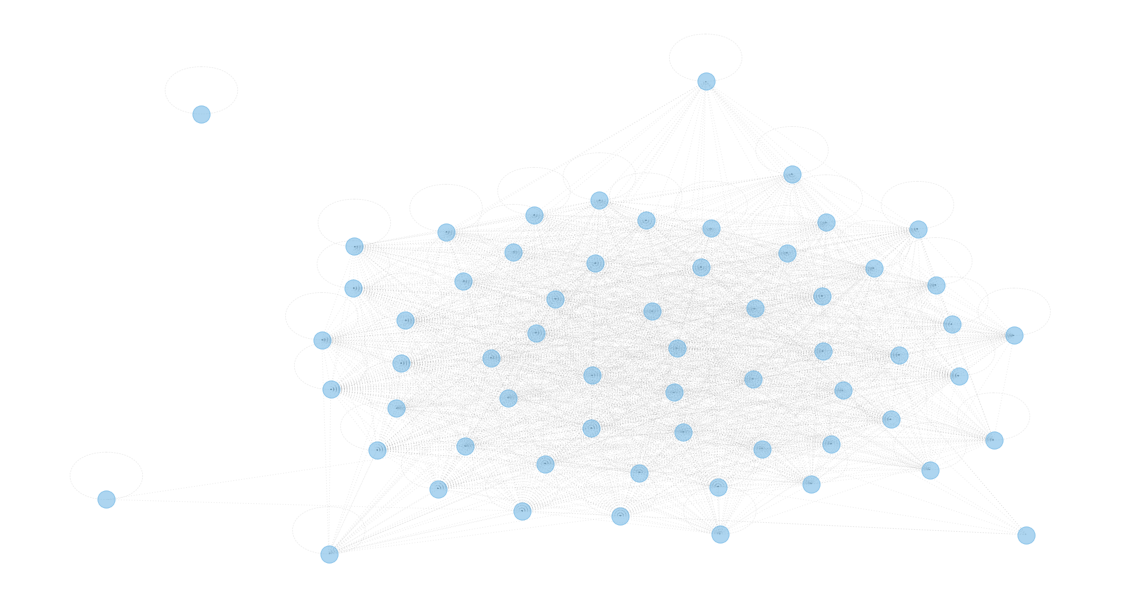

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

# Positions
df_station["pos"] = list(zip(df_station["long"].astype(float), df_station["lat"].astype(float)))
pos = df_station.to_dict()['pos']

for node, position in pos.items():
  try:
    U.nodes[node]['pos'] = position
  except KeyError:
    pass

pos = nx.spring_layout(U,k=2)
nx.draw_networkx_nodes(U,pos, node_color=BLUE, alpha=0.5)
nx.draw_networkx_edges(U,pos, edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
ax.axis('off')

# Create Directed Graph
A directed graph is graph, i.e., a set of objects (called vertices or nodes) that are connected together, where all the edges are directed from one vertex to another. A directed graph is sometimes called a digraph or a directed network.

In [7]:
G = nx.DiGraph()

## Nodes

In [8]:
node_list = [(k, v) for k, v in df_station.to_dict('index').items()]
G.add_nodes_from(node_list)

## Edges

In [9]:
edge_list = df_trip[['from_station_id','to_station_id']].to_numpy()

In [10]:
for edge in edge_list:
  G.add_edge(edge[0], edge[1])

## Drawing Graph

(-1.070110246672401,
 1.0040886938406406,
 -0.6911013799252644,
 1.1606928913051155)

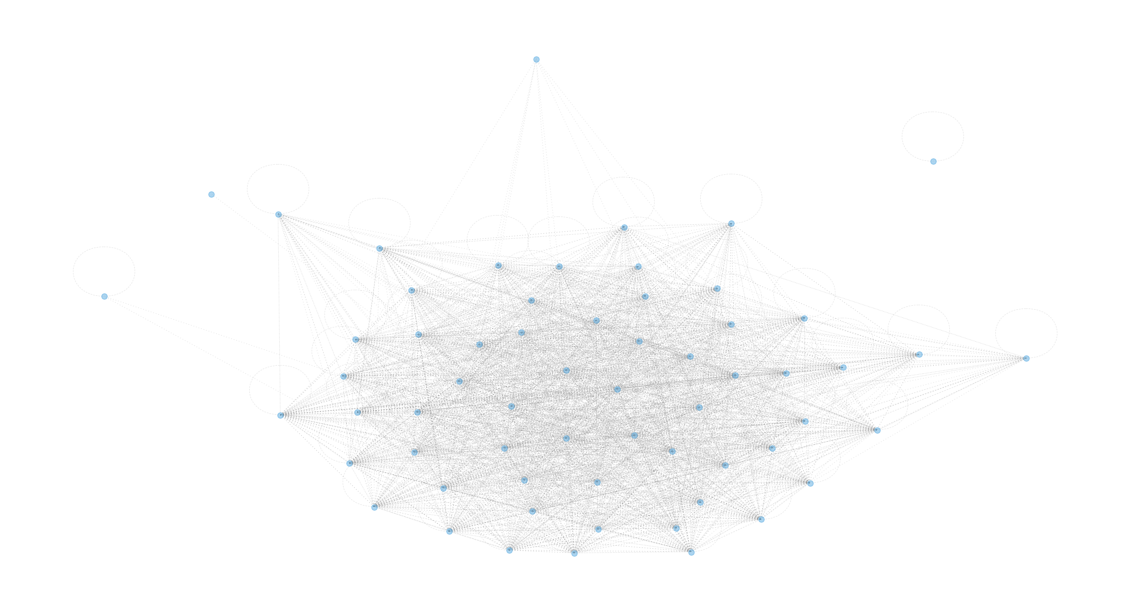

In [11]:
fig, ax = plt.subplots(figsize=(20,11))

pos = nx.spring_layout(G,k=2)
nx.draw_networkx_nodes(G,pos, node_color=BLUE, alpha=0.5, node_size= 30)
nx.draw_networkx_edges(G,pos, edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
ax.axis('off')

# Graph Analysis

### Degree, Average Degree and Degree Distribution
The node degree is the number of edges adjacent to the node. The weighted node degree is the sum of the edge weights for edges incident to that node. ... If None, then each edge has weight 1. The degree is the sum of the edge weights adjacent to the node.

In [13]:
g_ins = [d for (n, d) in G.in_degree()]
g_outs = [d for (n, d) in G.out_degree()]
u_degree_sequence = sorted([d for n, d in U.degree()], reverse=True)

in_h = Counter(g_ins)
in_dic = collections.OrderedDict(sorted(in_h.items()))
in_hist = list(in_dic.values())
in_values =list(in_dic.keys())

out_h =  Counter(g_outs)
out_dic = collections.OrderedDict(sorted(out_h.items()))
out_hist = list(out_dic.values())
out_values =list(out_dic.keys())

In [14]:
def g_degree_dist(degree_hist, degree_type):
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title(f'Directed Graph - {degree_type}-Degree Distribution')
    
    plt.show()

In [15]:
def u_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Unirected Graph - Degree Distribution')
    
    plt.show()

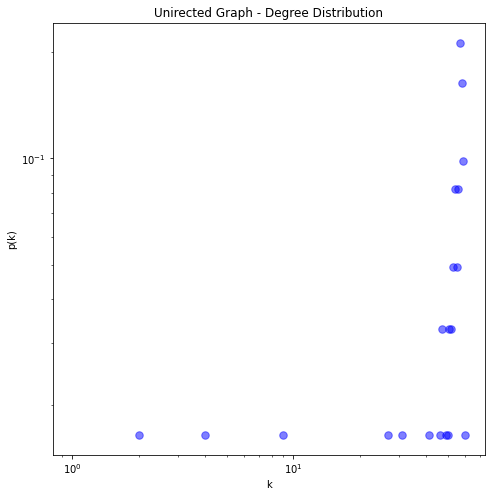

In [ ]:
u_degree_dist(U)

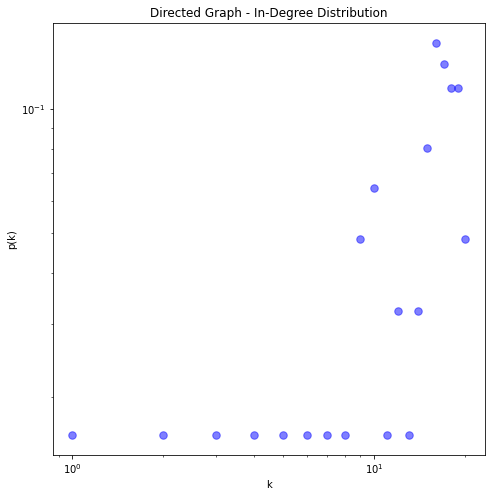

In [ ]:
g_degree_dist(in_hist, 'In')

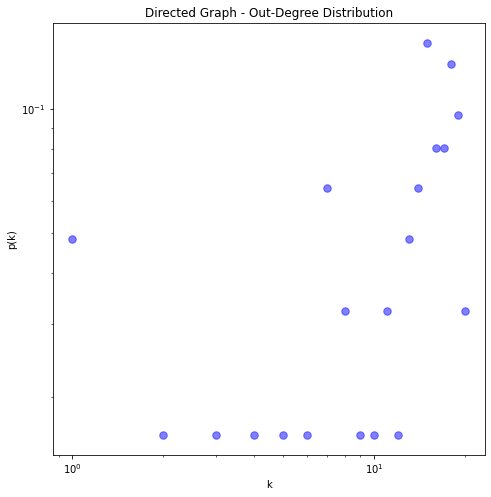

In [ ]:
g_degree_dist(out_hist, 'Out')

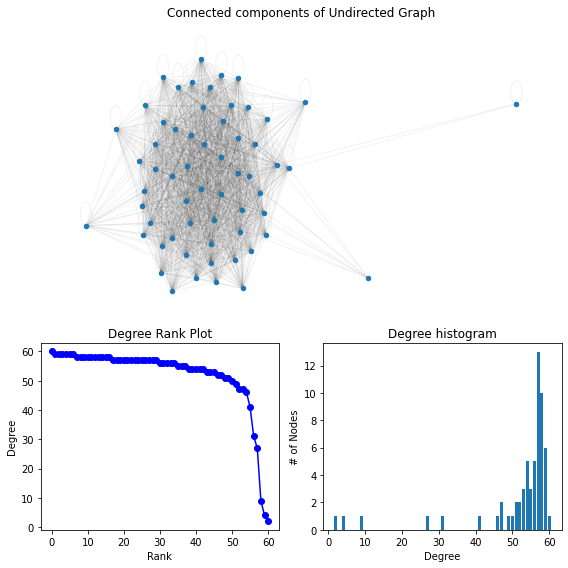

In [ ]:
dmax = max(u_degree_sequence)
fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = U.subgraph(sorted(nx.connected_components(U), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.05)
ax0.set_title("Connected components of Undirected Graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(u_degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(u_degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

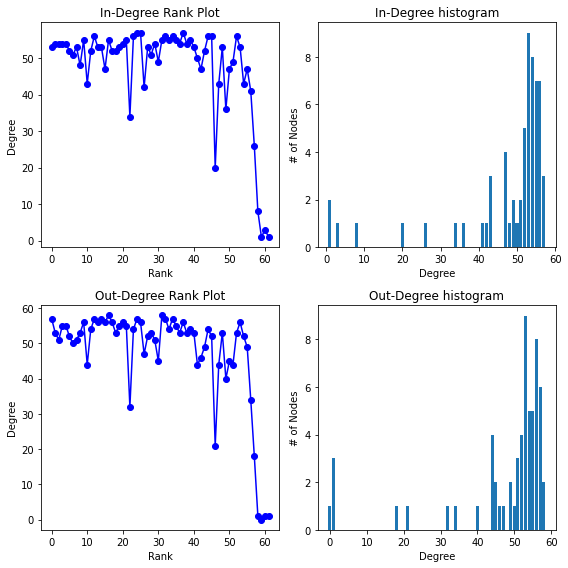

In [16]:
fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(6, 4)

ax1 = fig.add_subplot(axgrid[0:3, :2])
ax1.plot(g_ins, "b-", marker="o")
ax1.set_title("In-Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[0:3, 2:])
ax2.bar(*np.unique(g_ins, return_counts=True))
ax2.set_title("In-Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

ax3 = fig.add_subplot(axgrid[3:, :2])
ax3.plot(g_outs, "b-", marker="o")
ax3.set_title("Out-Degree Rank Plot")
ax3.set_ylabel("Degree")
ax3.set_xlabel("Rank")

ax4 = fig.add_subplot(axgrid[3:, 2:])
ax4.bar(*np.unique(g_outs, return_counts=True))
ax4.set_title("Out-Degree histogram")
ax4.set_xlabel("Degree")
ax4.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### Basic Network Stats
**Graph Density**

A first measure of the structure of a network is the so called density which measure how many links from all possible links within the network are realized.
The density is 0 if there are no edges, called empty graph and 1 if we have a complete Graph, all possible links between nodes are established.

In [17]:
def networkStats(G):
    """
    This function prints the basic properties of the network.
    """
    print(nx.info(G))
    print("L-max =",(int((G.number_of_nodes()*(G.number_of_nodes()-1))/2)))
    if not nx.is_directed(G):
      if nx.is_connected(G):
        print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
      else:
          print ('Graph not connected: infinite path length')
          print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))

    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))

    if not nx.is_directed(G):
      degree_dict = dict(G.degree(G.nodes()))
      nx.set_node_attributes(G, degree_dict, 'degree')

      sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
      print("\nTop 5 nodes by degree:\n")
      for d in sorted_degree[:5]:
          print(d)

    else:
      print ('Graph not connected: infinite path length')

      in_degree_dict = dict(G.in_degree(G.nodes()))
      out_degree_dict = dict(G.out_degree(G.nodes()))
      nx.set_node_attributes(G, in_degree_dict, 'in-degree')
      nx.set_node_attributes(G, out_degree_dict, 'ou-degree')

      sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
      sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
      print("\nTop 5 nodes by in-degree:\n")
      for d in sorted_in_degree[:5]:
          print(d)
      print("\nTop 5 nodes by out-degree:\n")
      for d in sorted_out_degree[:5]:
          print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

In [ ]:
networkStats(U)
print("\n----------------\n")
networkStats(G)

Graph with 61 nodes and 1584 edges
L-max = 1830
Graph not connected: infinite path length
Size of largest component: 60
Network density: 0.8655737704918033
Triadic closure: 0.9322115323834688
Degree Assortativity Coefficient (r): 0.004079171493044617

Top 5 nodes by degree:

('Lake Union Park / Valley St & Boren Ave N', 60)
('E Pine St & 16th Ave', 59)
('Fred Hutchinson Cancer Research Center / Fairview Ave N & Ward St', 59)
('REI / Yale Ave N & John St', 59)
('Dexter Ave N & Aloha St', 59)

Top 5 nodes by betweenness centrality:

('Terry Ave & Stewart St', 0.02101580624202878)
('City Hall / 4th Ave & James St', 0.018551344501962736)
('Lake Union Park / Valley St & Boren Ave N', 0.005914565907303892)
('12th Ave & E Denny Way', 0.005658458268190034)
('Dexter Ave N & Aloha St', 0.005647487240525829)

----------------

DiGraph with 62 nodes and 2944 edges
L-max = 1891
Network density: 0.7784241142252777
Triadic closure: 0.9005854037482487
Degree Assortativity Coefficient (r): 1.0000000000

### Betweenness Centrality
The betweenness centrality captures how much a given node is "in-between" others. This measure calculates the shortest paths between all the nodes of the network and assigns each node a measure based on the number of shortest paths going through the target node. The graph below illustrates the city bike stations by betweenness centrality.

In [18]:
def betweenness_centrality(Graph,GraphType): 
    """
    This function plots the city bike network betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title(f'{GraphType} Graph - Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

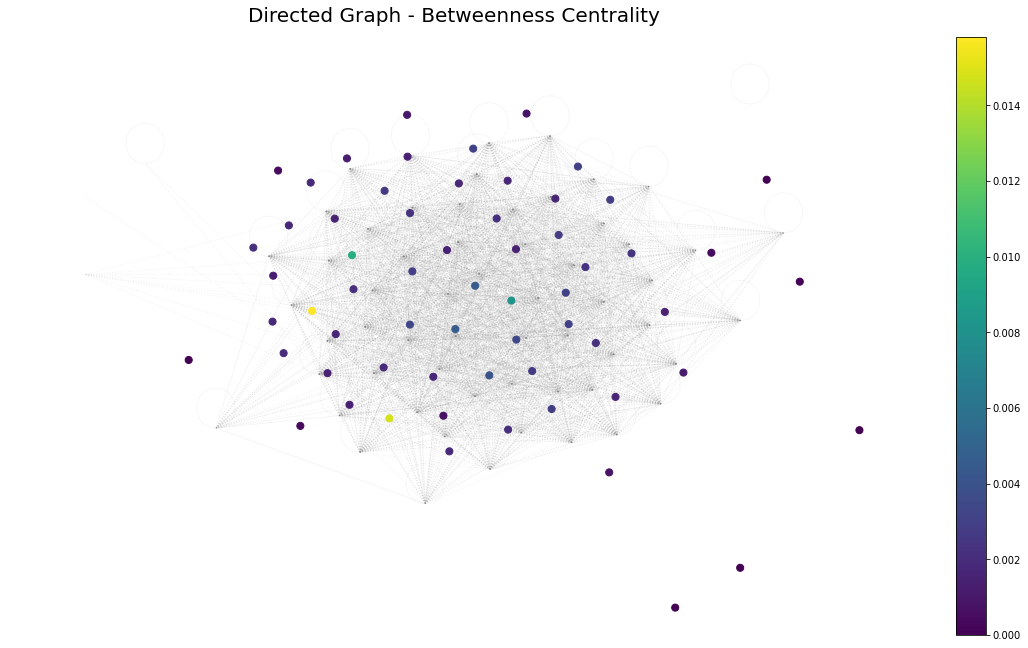

In [ ]:
betweenness_centrality(G, 'Directed')

In [19]:
betweenness = nx.betweenness_centrality(U)

In [20]:
max_node, max_bc = max(betweenness.items(), key=lambda x: x[1])
max_node, max_bc

('Terry Ave & Stewart St', 0.02101580624202878)

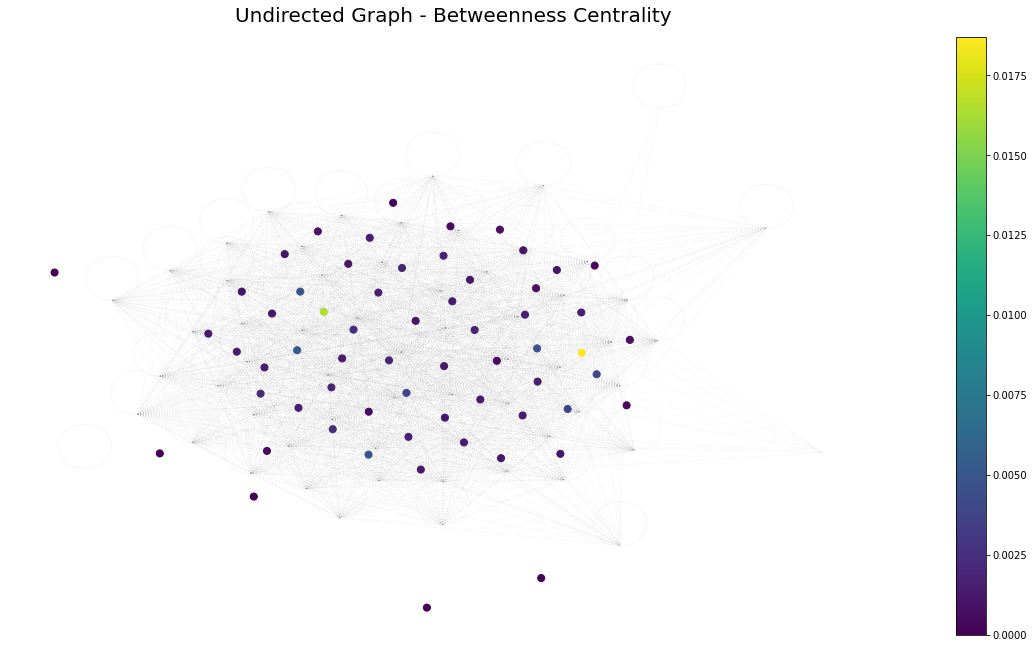

In [21]:
betweenness_centrality(U, 'Undirected')

### Degree Centrality
Degree centrality is the most simple centrality measure to understand and compute. "Degree" of a node refers to the number of nodes that a given node is connected to. Within the context of city bikes, this refers to the number of bike stations that users have travelled to from the target station. As we can see in the graph below stations located in central Seattle have a higher number of connections. 

In [22]:
def degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Undirected Graph - Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

In [23]:
def in_Degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.in_degree_centrality(G)

    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Directed Graph - In-Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

In [24]:
def out_Degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.out_degree_centrality(G)

    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Directed Graph - Out-Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

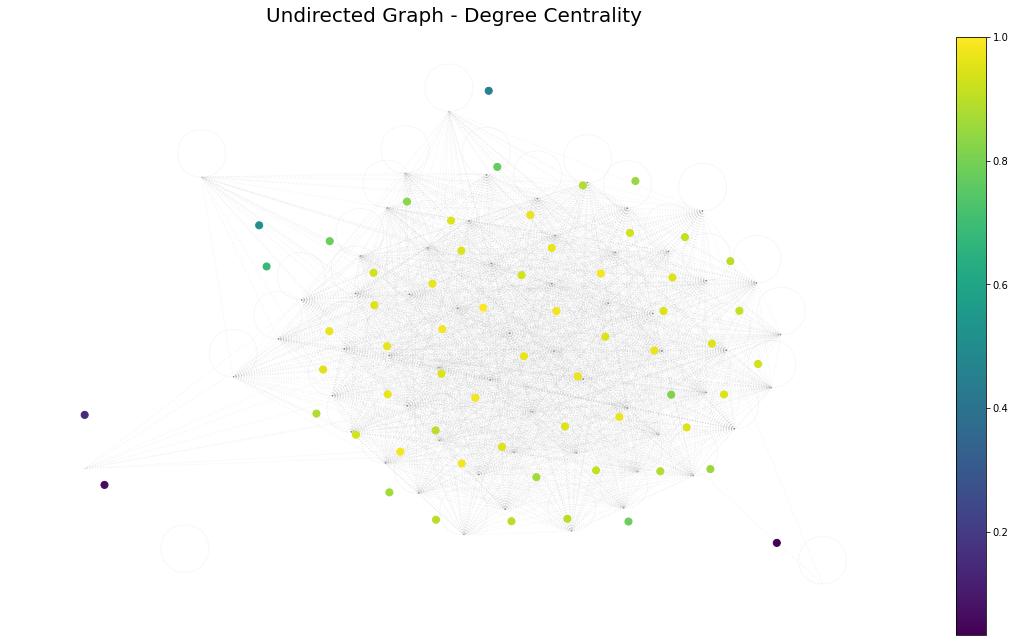

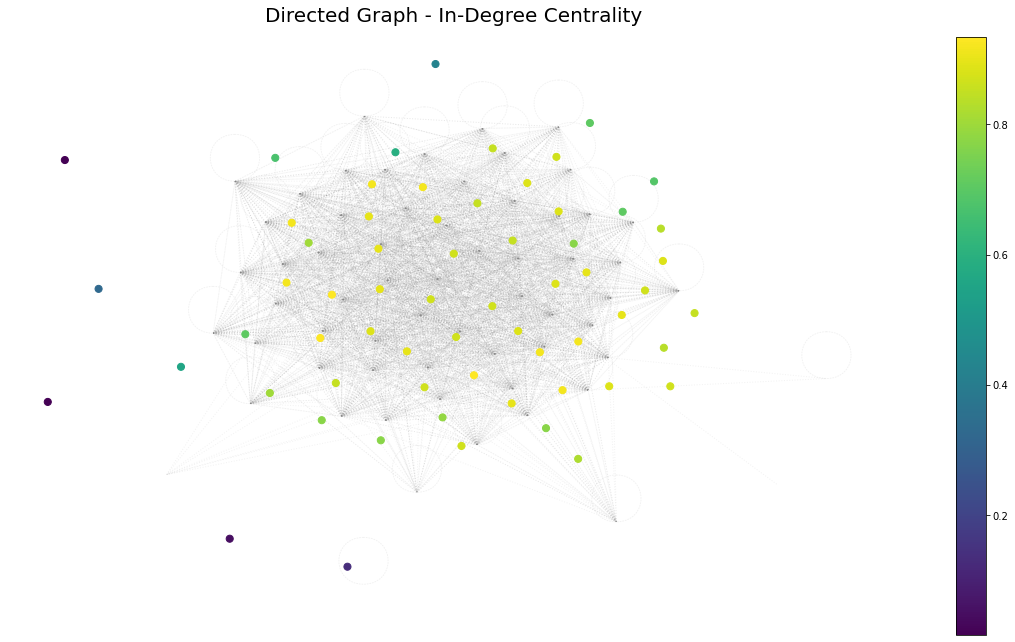

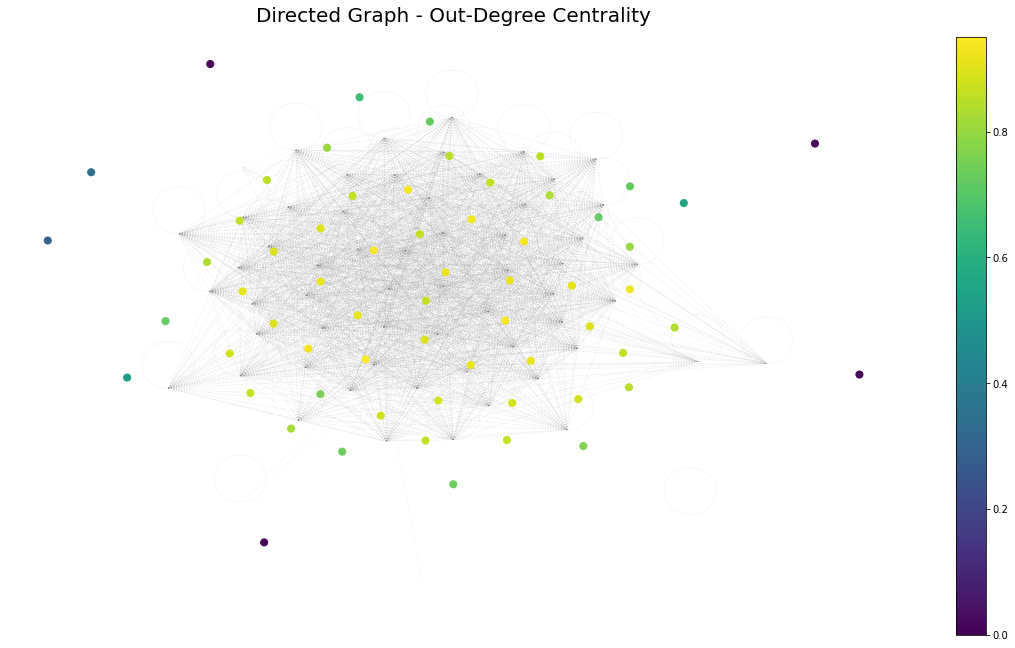

In [25]:
degree_centrality(U)
in_Degree_centrality(G)
out_Degree_centrality(G)

### Closeness Centrality
Closeness centrality is a way of detecting nodes that are able to distribute flows efficiently through the network. The closeness centrality is calculated as the normalized average of all of its geodesic distances. Within the context of the city bikes, a node with high closeness centrality will indicate stations that can potentially act as versatile intermediary stations within the network.

In [26]:
def closeness_centrality(G,GraphType):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title(f'{GraphType} Graph - Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

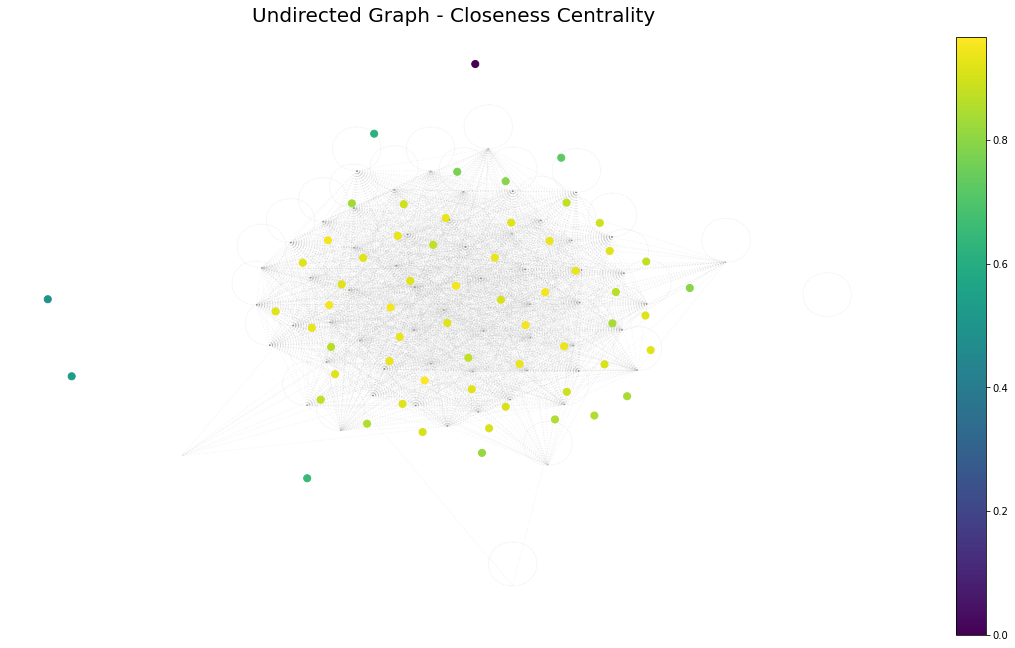

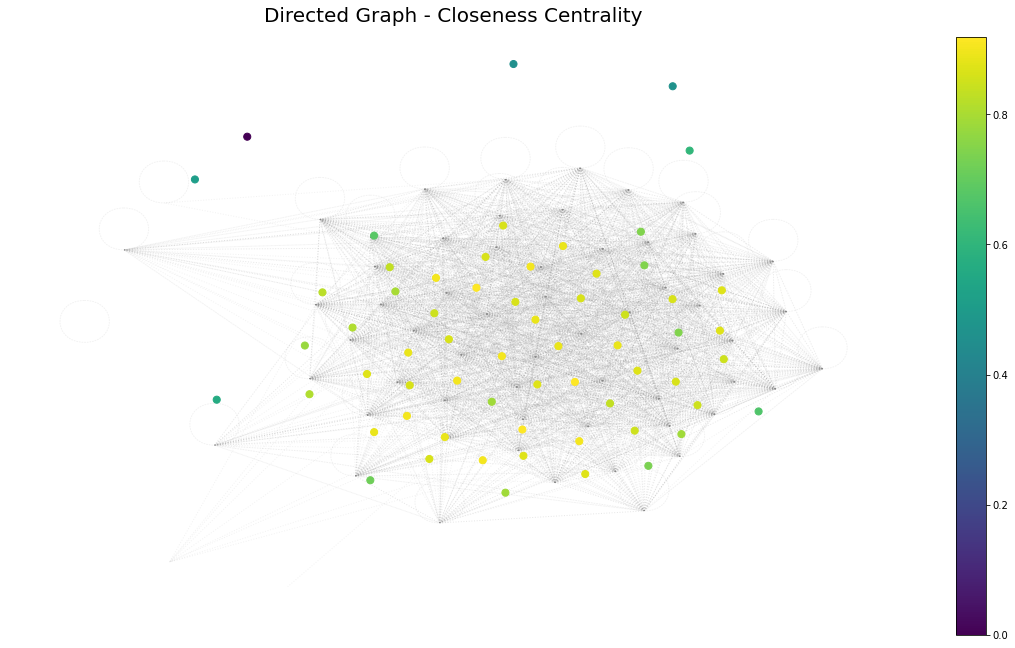

In [27]:
closeness_centrality(U, 'Undirected')
closeness_centrality(G, 'Directed')

In [29]:
closeness = nx.closeness_centrality(U)
max_node, max_bc = max(closeness.items(), key=lambda x: x[1])
max_node, max_bc

('Lake Union Park / Valley St & Boren Ave N', 0.9669444444444444)

### Clustering Coefficient
clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes.

In [30]:
def plot_clustering_coefficient(G, GraphType):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title(f'{GraphType} Graph - Average clustering coefficient')
    
    plt.show()

Average Clustering Coefficient of Directed Graph: 0.883



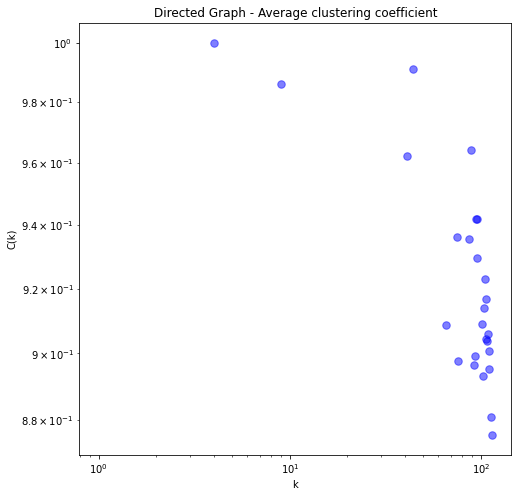

Average Clustering Coefficient of Unirected Graph: 0.922



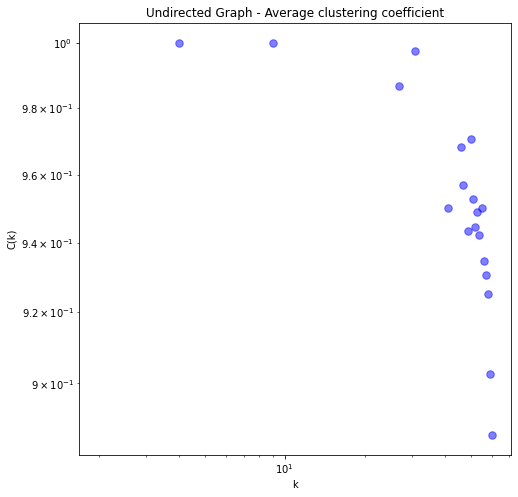

In [ ]:
print (f"Average Clustering Coefficient of Directed Graph: {round(nx.average_clustering(G),3)}\n") 
plot_clustering_coefficient(G, 'Directed')
print (f"Average Clustering Coefficient of Unirected Graph: {round(nx.average_clustering(U),3)}\n") 
plot_clustering_coefficient(U, 'Undirected')

### Community Detection
Communities in networks refer to groups of nodes that are densely connected internally. Community detection is often a crucial process for understanding the structure of complex networks. In the case of the city bike network, community detection can help to better understand bike usage patterns and determine adequate pricing models. There is a number of algorithms available for community detection

#### Girvan Newman method
The Girvan- Newman method for the detection and analysis of community structure is based on the iterative elimination of edges with the highest number of the shortest paths that go through them. By eliminating edges the network breaks down into smaller networks, i.e. communities.

In [31]:
from networkx.algorithms import community
import itertools

In [ ]:
communities_list =[]
k = 1
comp = community.girvan_newman(G)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))
    communities_list.append(tuple(sorted(c) for c in communities))

(['BT-01', 'BT-03', 'BT-04', 'BT-05', 'CBD-03', 'CBD-04', 'CBD-05', 'CBD-06', 'CBD-07', 'CBD-13', 'CD-01', 'CH-01', 'CH-02', 'CH-03', 'CH-05', 'CH-06', 'CH-07', 'CH-08', 'CH-09', 'CH-12', 'CH-15', 'CH-16', 'DPD-01', 'DPD-03', 'EL-01', 'EL-03', 'EL-05', 'FH-01', 'FH-04', 'ID-04', 'PS-04', 'PS-05', 'Pronto shop', 'Pronto shop 2', 'SLU-01', 'SLU-02', 'SLU-04', 'SLU-07', 'SLU-15', 'SLU-16', 'SLU-17', 'SLU-18', 'SLU-19', 'SLU-20', 'SLU-21', 'SLU-22', 'UD-01', 'UD-02', 'UD-04', 'UD-07', 'UW-01', 'UW-02', 'UW-04', 'UW-06', 'UW-07', 'UW-10', 'UW-11', 'WF-01', 'WF-03', 'WF-04'], ['SLU-15trip_id"'], ['8D OPS 02'])


In [ ]:
community_index = {}
for communities in communities_list:
  for i,community in enumerate(communities):
    for node in community:
      community_index[node] = i

In [ ]:
nx.set_node_attributes(G, community_index, "community")

(-1.125221397238759, 1.065178039760659, -1.188041710336024, 1.1041924623969535)

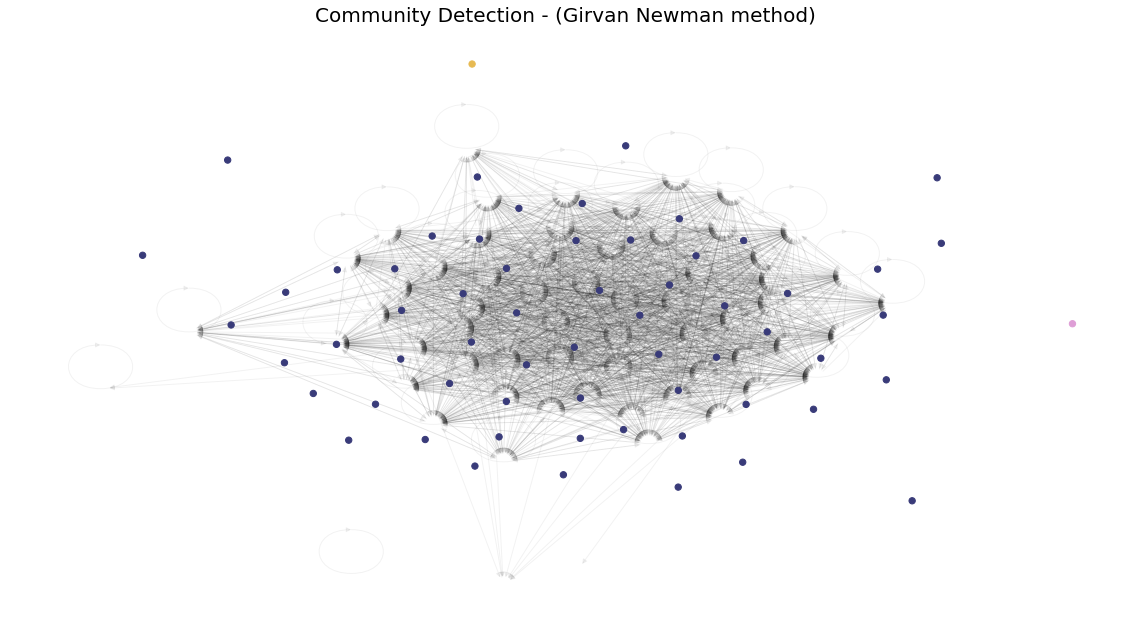

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

cmap = cm.get_cmap('tab20b', max(community_index.values()) + 1)

# Draw Nodes & Edges
nx.draw_networkx_nodes(G, 
                       pos=nx.spring_layout(G,k=2),
                       nodelist=community_index.keys(), 
                       node_size=40, 
                       cmap=cmap,
                       node_color=list(community_index.values()))
nx.draw_networkx_edges(G, pos=nx.spring_layout(G,k=2), alpha=0.05)

# Labeling Axes
ax.set_title('Community Detection - (Girvan Newman method)', fontdict={"fontsize":20}, pad = 15)
ax.axis('off')

#### Label Propagation method
The Label Propagation algorithm (LPA) is a fast algorithm for finding communities in a graph. It detects these communities using network structure alone as its guide, and doesn't require a pre-defined objective function or prior information about the communities.

In [ ]:
from networkx.algorithms.community import label_propagation

In [ ]:
communities=label_propagation.label_propagation_communities(U)

In [ ]:
community_index = {}
for community_number,community in enumerate(communities):
  for node in community:
    community_index[node]=community_number

In [ ]:
nx.set_node_attributes(U, community_index, "community")

(-0.748608616573661, 1.166157379855416, -0.991183289075031, 0.857182645199074)

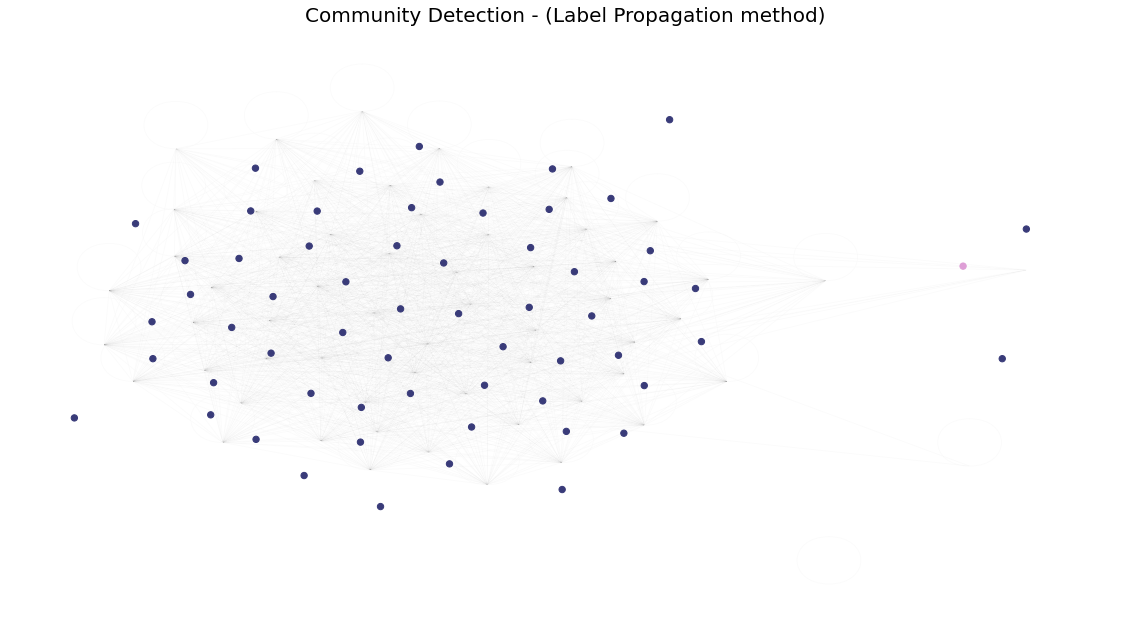

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

cmap = cm.get_cmap('tab20b', max(community_index.values()) + 1)

# Draw Nodes & Edges
nx.draw_networkx_nodes(U, 
                       pos=nx.spring_layout(U,k=2),
                       nodelist=community_index.keys(), 
                       node_size=40, 
                       cmap=cmap,
                       node_color=list(community_index.values()))
nx.draw_networkx_edges(U, pos=nx.spring_layout(U,k=2), alpha=0.015)

# Labeling Axes
ax.set_title('Community Detection - (Label Propagation method)', fontdict={"fontsize":20}, pad = 15)
ax.axis('off')

### knn- K Nearest Neighbors
Compute the average degree connectivity of graph.

The average degree connectivity is the average nearest neighbor degree of
nodes with degree k.

In [ ]:
def fit_func(x,a,mu):
    return (a*x)**mu

In [ ]:
def plot_knn(G, GraphType, fit=True): 
    knn_dict = nx.average_degree_connectivity(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title(f'{GraphType} Graph - Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

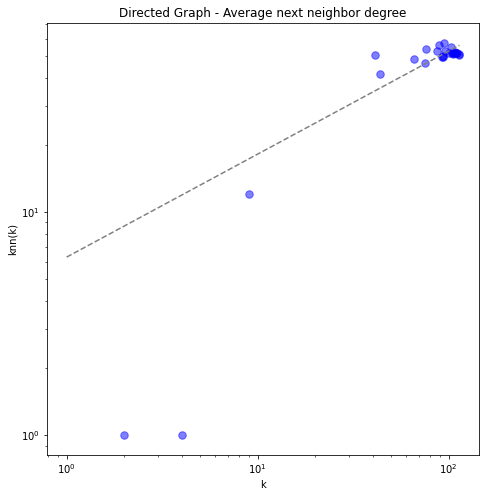

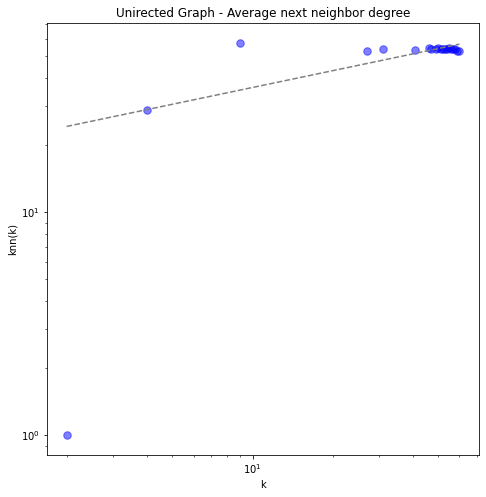

In [ ]:
plot_knn(G, 'Directed')
plot_knn(U, 'Unirected')

# Conclusion
the Seattle city bike network was briefly analyzed as a complex network. Multiple centrality measures were applied to the network and important centres were identified. Two community detection algorithms revealed different possible groupings of the nodes within the network.